In [2]:
import torch
import torchvision
import torchvision.transforms as transforms # 다양한 이미지 변환 기능들을 제공해줌

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
# R, G, B 채널마다 0~255사이의 값인데 torchvision으로 불러오는 데이터셋은 0~1 범위의 PILImage이다.
# 이러한 이미지를 -1~1 범위로 사용하기 위해 Tensor로 정규화시켜준다. (평균:0.5, 표준편차:0.5)

#데이터 불러오기 학습여부 o
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

#학습용 셋은 섞어서 뽑기
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

#데이터 불러오기 학습여부 x
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

#테스트 셋은 굳이 섞을 필요가 없음
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

#클래스들
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#num_workers의 개수는 보통 코어의 절반정도라고 한다.

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


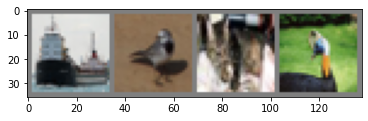

 ship  bird   cat  bird


In [9]:
# 이미지 확인
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5 # 정규화 해제 -> (-1,1) 을 (0,1) 로 바꿔줌
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0))) # C H W -> H W C 로 바꿔줌
  plt.show()

# 학습용 이미지 뽑기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
# CNN 정의하기, LeNet-5 알고리즘
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    # input = 3, output = 6, kernal = 5
    self.conv1 = nn.Conv2d(3, 6, 5) # 32X32 에서 28X28 됨
    # kernal = 2, stride = 2, padding = 0 (default)
    self.pool = nn.MaxPool2d(2,2) # 28X28 에서 14X14 됨
    self.conv2 = nn.Conv2d(6, 16, 5) # 14X14 에서 10X10 됨

    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()

In [11]:
# Loss와 Optimizer 정의하기
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
# 학습하기
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader):
    inputs, labels = data

    # 학습
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # 결과 출력
    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss : %.3f' % (epoch+1, i+1, running_loss / 2000))
      running_loss = 0.0

print('Finished Training')

[1,  2000] loss : 1.501
[1,  4000] loss : 1.470
[1,  6000] loss : 1.419
[1,  8000] loss : 1.383
[1, 10000] loss : 1.366
[1, 12000] loss : 1.338
[2,  2000] loss : 1.287
[2,  4000] loss : 1.274
[2,  6000] loss : 1.246
[2,  8000] loss : 1.239
[2, 10000] loss : 1.246
[2, 12000] loss : 1.239
Finished Training


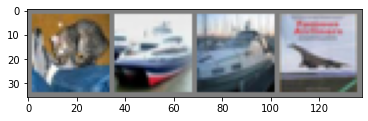

GroundTruth:  5cat 5ship 5ship 5plane
Predicted:  5cat 5ship 5ship 5ship


In [15]:
testiter = iter(testloader)
images, labels = testiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('5%s' % classes[labels[j]] for j in range(4)))

# 학습한 모델로 예측값 뽑아보기
outputs = net(images)
_, predicted = torch.max(outputs,1)
print('Predicted: ', ' '.join('5%s' % classes[predicted[j]] for j in range(4)))

In [18]:
# 전체 데이터셋
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' %(100*correct/total))


Accuracy of the network on the 10000 test images: 57 %
